In [1]:
import pandas as pd
import Helper
import numpy as np

data = pd.read_csv('Data/PvsUdata/MergedData2.csv')

In [8]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['trial', 'sample', 'revenue_P', 'revenue_U', 'revenue_diff_U-P'])  # Features
Y = (data['revenue_U'] > data['revenue_P']).astype(int)  # Target: 1 if UEEE wins, 0 if PEEE wins

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

77.66666666666667 22.333333333333332
Data less than -2 std dev:  18
Data between -2 and -1 std dev:  73
Data between -1 and mean:  201
Data between mean and +1 std dev:  220
Data between +1 and +2 std dev:  71
Data greater than +2 std dev:  17


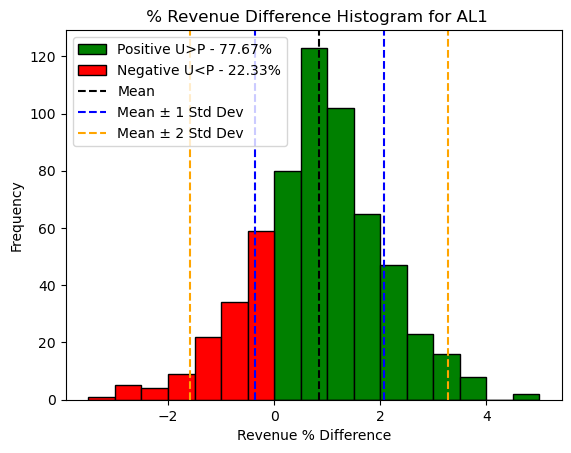

In [9]:
Helper.win_loss_histogram((data['revenue_diff_U-P']*100/data['revenue_P']),carrier='AL1',num_bins=15, strategy1='U', strategy2='P')

In [10]:
# transform certain features based on their distribution to match gaussian distribution
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer
pt = PowerTransformer()

# the features to transform are the ones if they have Pos or Neg in the name
features_to_transform = [col for col in X_train.columns if 'Pos' in col or 'Neg' in col]

# Apply the transformation
X_train[features_to_transform] = pt.fit_transform(X_train[features_to_transform])
X_test[features_to_transform] = pt.transform(X_test[features_to_transform])


In [11]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

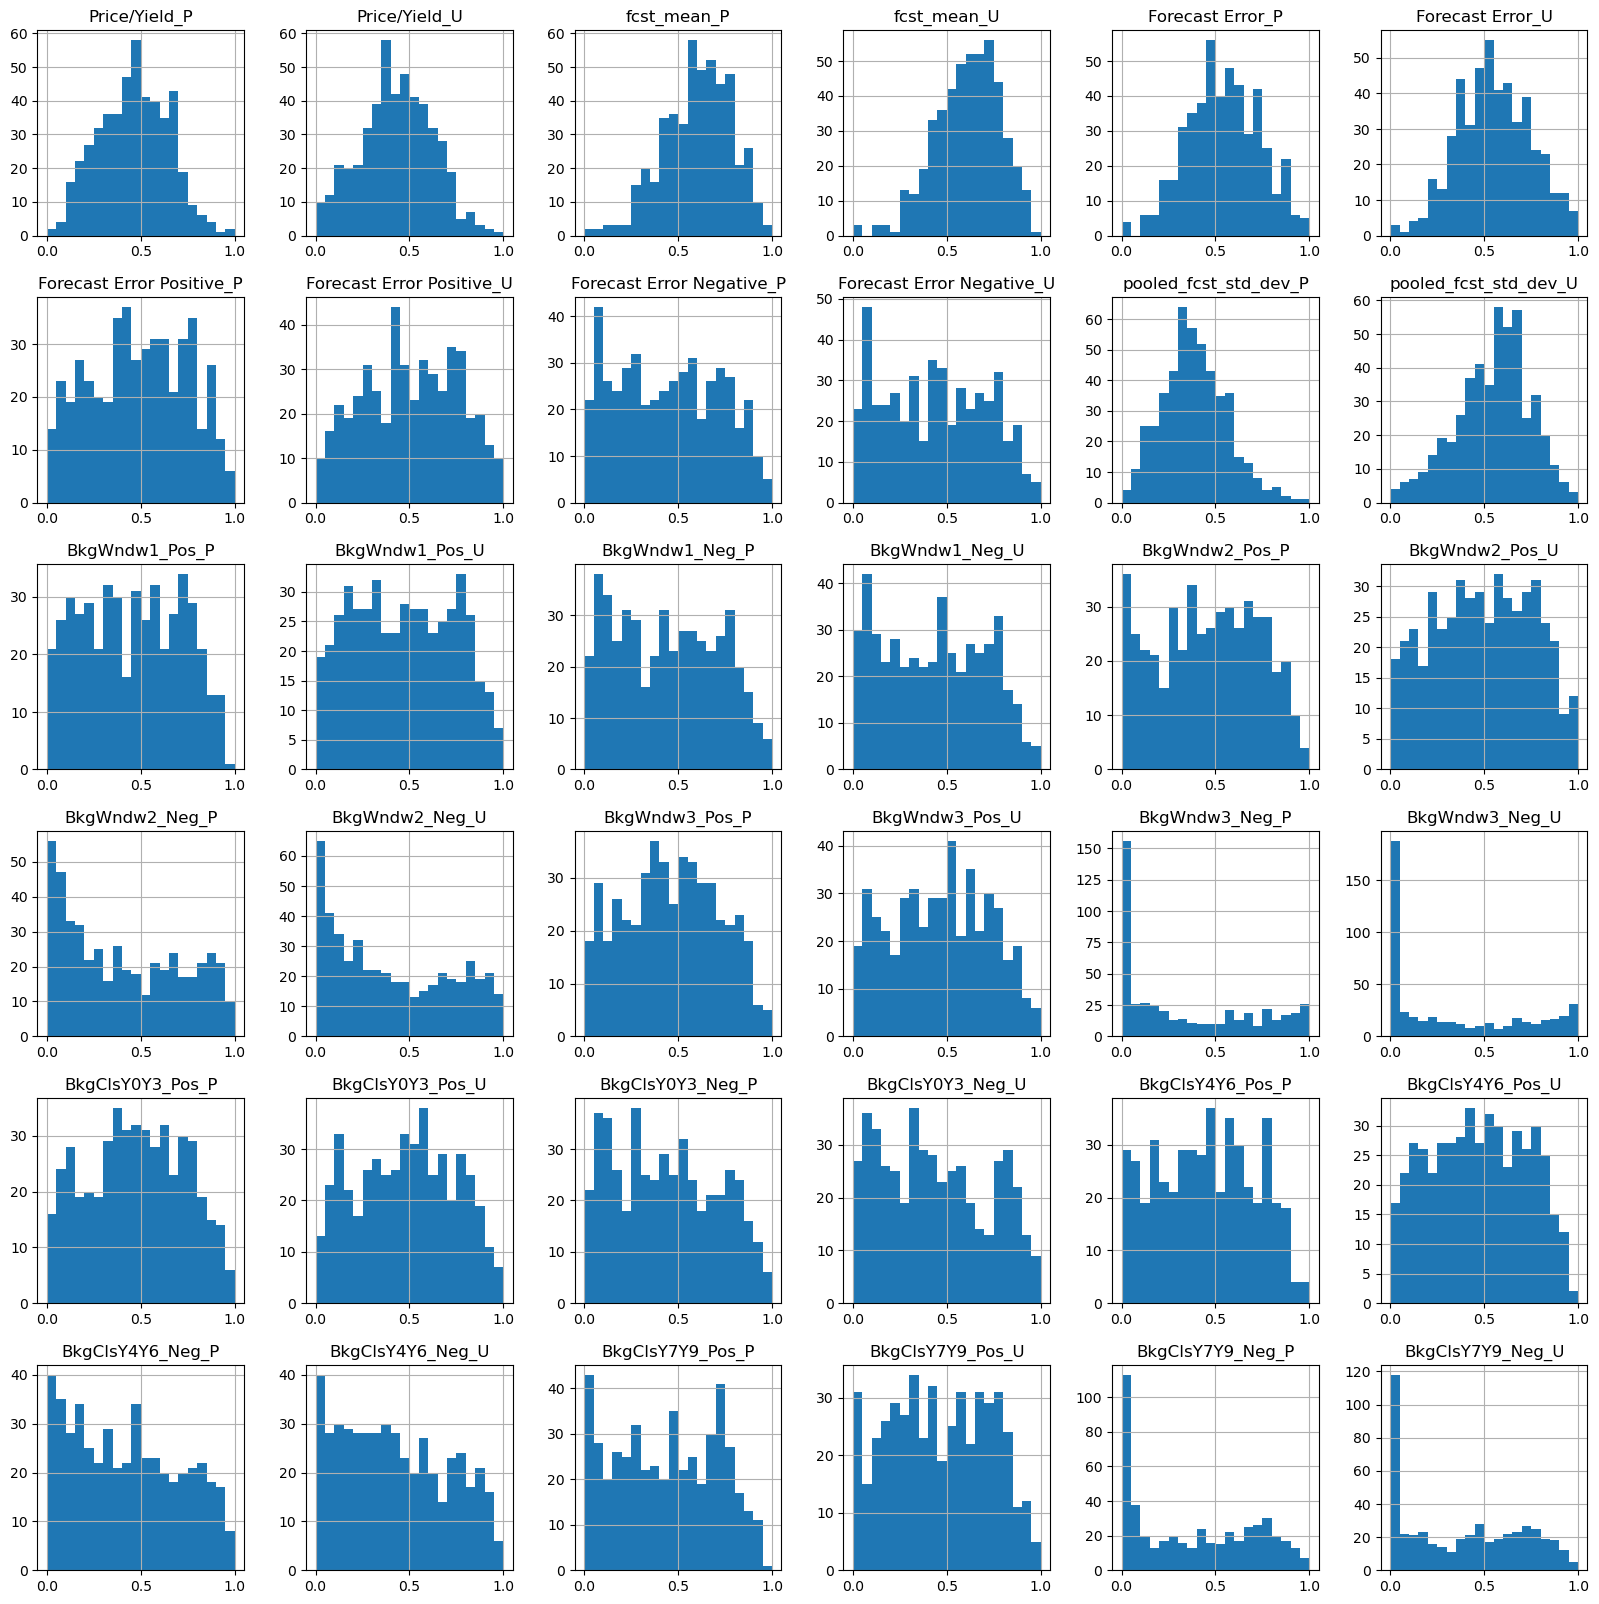

In [ ]:
import matplotlib.pyplot as plt
X_train.hist(bins=20, figsize=(20, 20))
plt.show()

In [12]:
# correlation values for all features with respect to the target (Y)
correlation = X_train.corrwith(Y_train)
correlation = correlation.sort_values(ascending=False)
correlation

BkgClsY4Y6_Pos_U             0.046252
BkgClsY4Y6_Pos_P             0.031807
BkgClsY7Y9_Neg_U             0.031173
BkgWndw2_Neg_P               0.021874
BkgWndw3_Neg_P               0.021046
BkgWndw3_Pos_P               0.020994
BkgWndw3_Pos_U               0.018263
BkgWndw1_Neg_U               0.017686
Price/Yield_U                0.017546
BkgClsY0Y3_Neg_P             0.016039
BkgClsY7Y9_Neg_P             0.015273
BkgWndw2_Pos_U               0.012699
Forecast Error Negative_P    0.011504
BkgClsY0Y3_Pos_P             0.010772
BkgWndw2_Pos_P               0.010412
Forecast Error Negative_U    0.008157
BkgWndw1_Neg_P               0.007235
BkgWndw3_Neg_U               0.006205
Forecast Error Positive_P    0.005515
Forecast Error Positive_U    0.004303
Forecast Error_P             0.003344
fcst_mean_P                  0.001489
pooled_fcst_std_dev_U        0.001293
BkgWndw2_Neg_U               0.001213
BkgClsY0Y3_Pos_U             0.001107
BkgClsY0Y3_Neg_U            -0.000907
BkgWndw1_Pos

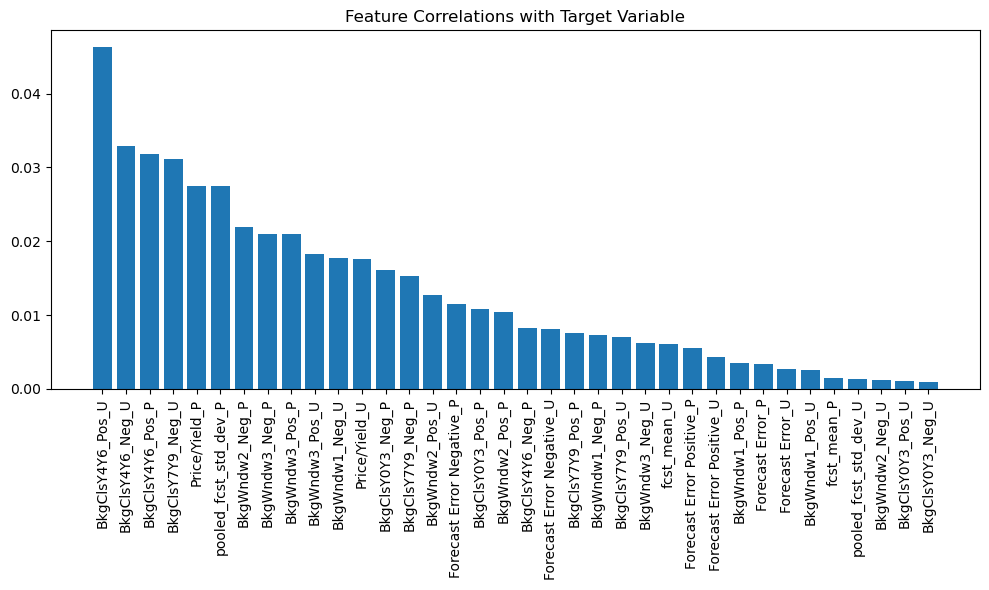


Correlation coefficients with target variable:
                      feature  correlation
29           BkgClsY4Y6_Pos_U     0.046252
31           BkgClsY4Y6_Neg_U     0.032860
28           BkgClsY4Y6_Pos_P     0.031807
35           BkgClsY7Y9_Neg_U     0.031173
0               Price/Yield_P     0.027468
10      pooled_fcst_std_dev_P     0.027445
18             BkgWndw2_Neg_P     0.021874
22             BkgWndw3_Neg_P     0.021046
20             BkgWndw3_Pos_P     0.020994
21             BkgWndw3_Pos_U     0.018263
15             BkgWndw1_Neg_U     0.017686
1               Price/Yield_U     0.017546
26           BkgClsY0Y3_Neg_P     0.016039
34           BkgClsY7Y9_Neg_P     0.015273
17             BkgWndw2_Pos_U     0.012699
8   Forecast Error Negative_P     0.011504
24           BkgClsY0Y3_Pos_P     0.010772
16             BkgWndw2_Pos_P     0.010412
30           BkgClsY4Y6_Neg_P     0.008290
9   Forecast Error Negative_U     0.008157
32           BkgClsY7Y9_Pos_P     0.007622
14    

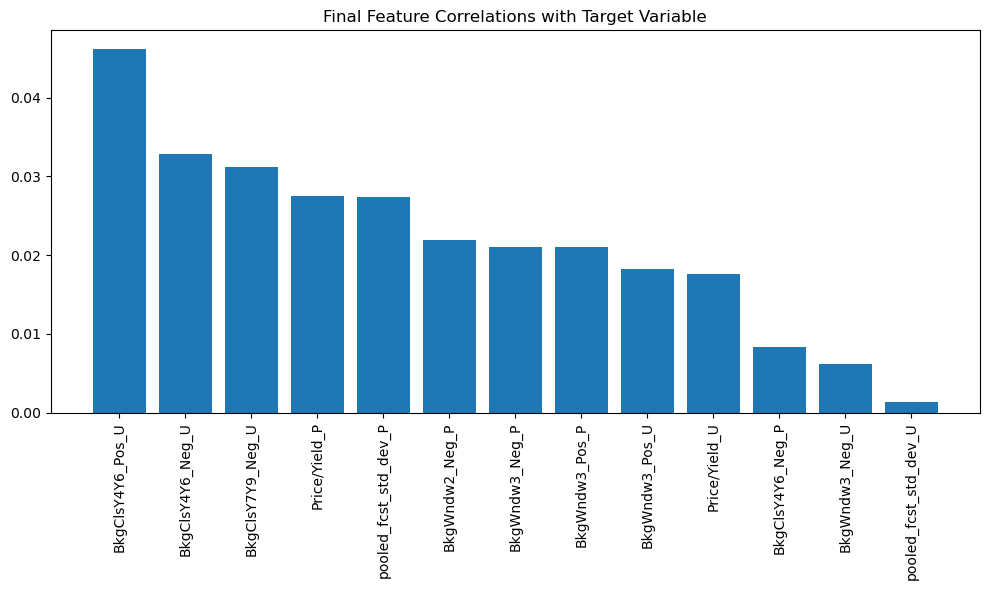

In [13]:
import matplotlib.pyplot as plt


# feature reduction using pearson correlation
# Calculate correlations with target variable
correlations = pd.DataFrame()
correlations['feature'] = X_train.columns
correlations['correlation'] = [abs(X_train[col].corr(Y_train)) for col in X_train.columns]
correlations = correlations.sort_values('correlation', ascending=False)

# Plot correlation with target
plt.figure(figsize=(10, 6))
plt.bar(correlations['feature'], correlations['correlation'])
plt.xticks(rotation=90)
plt.title('Feature Correlations with Target Variable')
plt.tight_layout()
plt.show()

# Print correlation coefficients
print("\nCorrelation coefficients with target variable:")
print(correlations)

# Make copies of original data
X_train_trim = X_train.copy()
X_test_trim = X_test.copy()

# Get correlation matrix between features
corr_matrix = X_train.corr().abs()

# Find highly correlated feature pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
features_to_drop = []

for col in upper.columns:
    # Find features that are highly correlated with current column
    highly_corr = upper[col][upper[col] > 0.95].index.tolist()
    if highly_corr:
        # For each pair, keep feature with higher correlation to target
        for feat in highly_corr:
            corr_col = abs(X_train[col].corr(Y_train))
            corr_feat = abs(X_train[feat].corr(Y_train))
            if corr_col < corr_feat:
                features_to_drop.append(col)
            else:
                features_to_drop.append(feat)

# Remove duplicate features to drop
features_to_drop = list(set(features_to_drop))

# Remove highly correlated features
X_train_trim = X_train_trim.drop(columns=features_to_drop)
X_test_trim = X_test_trim.drop(columns=features_to_drop)

print("\nFeatures dropped due to high correlation:")
print(features_to_drop)

print("\nFinal set of features:")
print(X_train_trim.columns.tolist())

# Plot final feature correlations with target
final_correlations = pd.DataFrame()
final_correlations['feature'] = X_train_trim.columns
final_correlations['correlation'] = [abs(X_train_trim[col].corr(Y_train)) for col in X_train_trim.columns]
final_correlations = final_correlations.sort_values('correlation', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(final_correlations['feature'], final_correlations['correlation'])
plt.xticks(rotation=90)
plt.title('Final Feature Correlations with Target Variable')
plt.tight_layout()
plt.show()


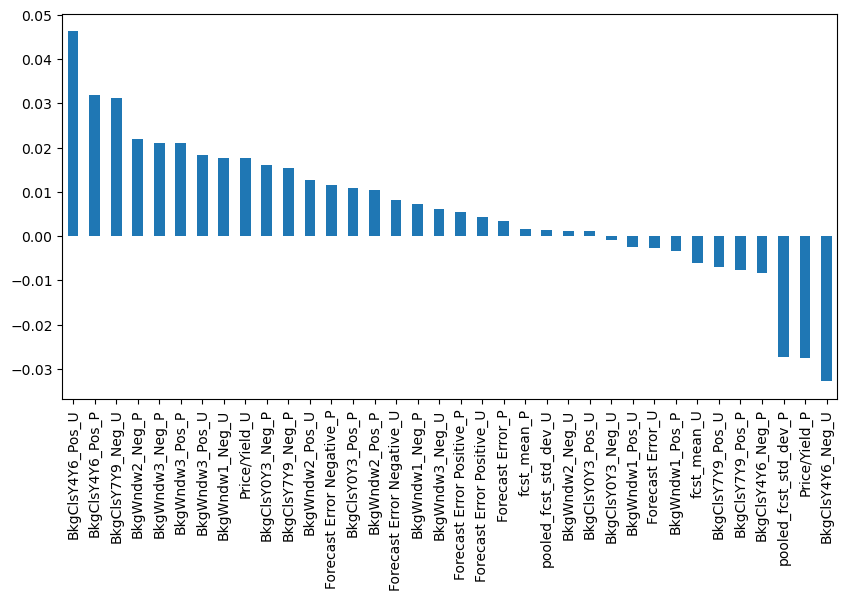

In [14]:
# plot the correlation values
plt.figure(figsize=(10, 5))
correlation.plot(kind='bar')
plt.show()

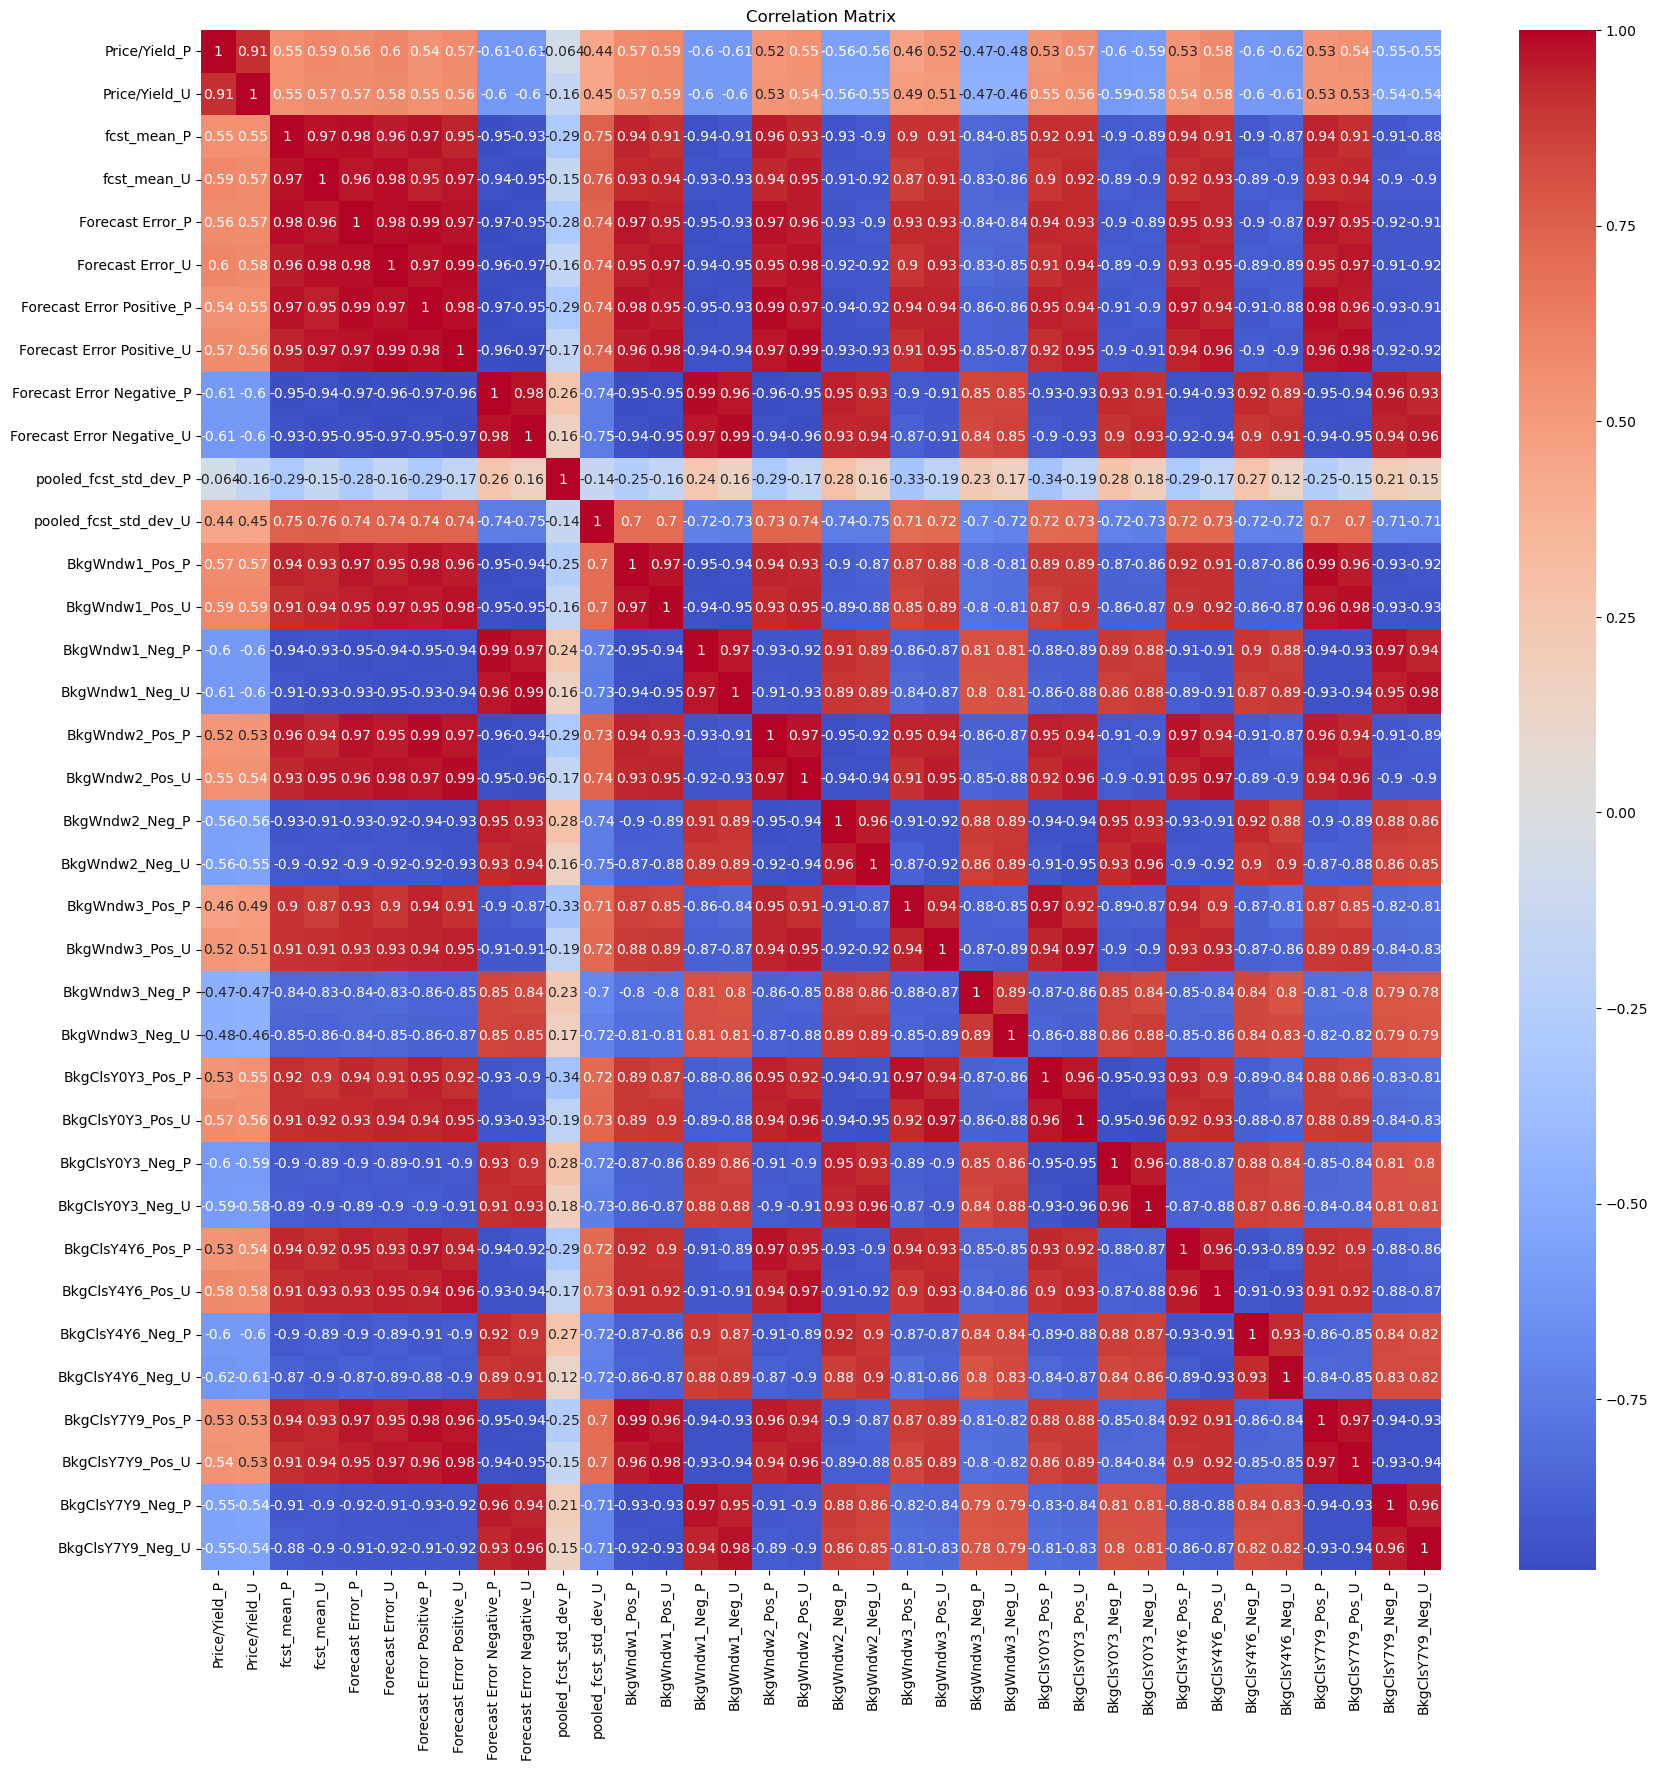

In [15]:
# correlation matrix heatmap
import seaborn as sns
corr_matrix = X_train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
# show highly correlated feature pairs
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(ascending=False)
strong_pairs = sorted_pairs[(sorted_pairs > 0.95) & (sorted_pairs < 1)]
for pair, value in strong_pairs.items():
    print(f"{pair}: {value}")

('Forecast Error Positive_U', 'BkgWndw2_Pos_U'): 0.9908669279327917
('BkgWndw2_Pos_U', 'Forecast Error Positive_U'): 0.9908669279327917
('Forecast Error Negative_P', 'BkgWndw1_Neg_P'): 0.9900047070514162
('BkgWndw1_Neg_P', 'Forecast Error Negative_P'): 0.9900047070514162
('BkgWndw2_Pos_P', 'Forecast Error Positive_P'): 0.9895329515737221
('Forecast Error Positive_P', 'BkgWndw2_Pos_P'): 0.9895329515737221
('BkgWndw1_Neg_U', 'Forecast Error Negative_U'): 0.9894352607120661
('Forecast Error Negative_U', 'BkgWndw1_Neg_U'): 0.9894352607120661
('Forecast Error_P', 'Forecast Error Positive_P'): 0.9880089219767678
('Forecast Error Positive_P', 'Forecast Error_P'): 0.9880089219767678
('Forecast Error_U', 'Forecast Error Positive_U'): 0.9879611563961647
('Forecast Error Positive_U', 'Forecast Error_U'): 0.9879611563961647
('BkgWndw1_Pos_P', 'BkgClsY7Y9_Pos_P'): 0.98539752414317
('BkgClsY7Y9_Pos_P', 'BkgWndw1_Pos_P'): 0.98539752414317
('Forecast Error_P', 'Forecast Error_U'): 0.9833232912492552
(

In [17]:
# Define the specific features we want to keep
selected_features = [
    'Price/Yield_U',
    'Price/Yield_P',
    'pooled_fcst_std_dev_P', 
    'pooled_fcst_std_dev_U',
    'BkgWndw2_Pos_P',
    'BkgWndw3_Pos_P',
    'BkgWndw3_Neg_P',
    'BkgWndw3_Pos_U',
    'BkgClsY4Y6_Pos_U',
    'BkgClsY4Y6_Neg_U',
    'BkgClsY7Y9_Neg_P'
]

# Create new trimmed datasets with only these features
X_train_trim = X_train[selected_features]
X_test_trim = X_test[selected_features]

# Verify the features
print("Selected features:")
print(X_train_trim.columns.tolist())

# Show shape of trimmed datasets
print("\nShape of trimmed training data:", X_train_trim.shape)
print("Shape of trimmed test data:", X_test_trim.shape)


Selected features:
['Price/Yield_U', 'Price/Yield_P', 'pooled_fcst_std_dev_P', 'pooled_fcst_std_dev_U', 'BkgWndw2_Pos_P', 'BkgWndw3_Pos_P', 'BkgWndw3_Neg_P', 'BkgWndw3_Pos_U', 'BkgClsY4Y6_Pos_U', 'BkgClsY4Y6_Neg_U', 'BkgClsY7Y9_Neg_P']

Shape of trimmed training data: (480, 11)
Shape of trimmed test data: (120, 11)


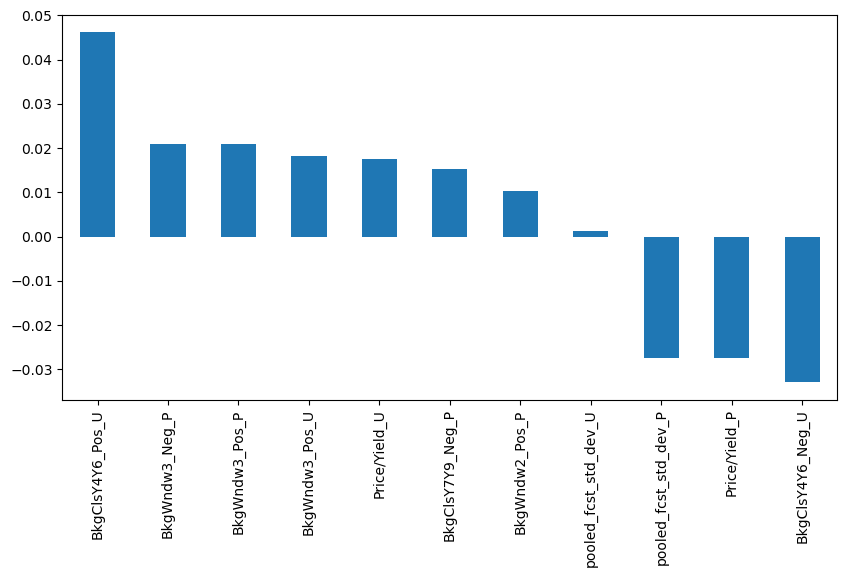

In [18]:
# plot the correlation values
correlation = X_train_trim.corrwith(Y_train)
correlation = correlation.sort_values(ascending=False)
plt.figure(figsize=(10, 5))
correlation.plot(kind='bar')
plt.show()

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_trim, Y_train)
print(Counter(Y_train_resampled))

Counter({1: 379, 0: 379})


In [20]:
# export the training and testing data separately 
X_train_resampled.to_csv('Data/PvsUdata/X_train_resampled.csv', index=False)
X_test_trim.to_csv('Data/PvsUdata/X_test.csv', index=False)
Y_train_resampled.to_csv('Data/PvsUdata/Y_train_resampled.csv', index=False)
Y_test.to_csv('Data/PvsUdata/Y_test.csv', index=False)
